All work was done in [colab](colab.research.google.com)

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
%%time
!unzip /gdrive/My\ Drive/train.zip -d . >> /dev/null
!unzip /gdrive/My\ Drive/val.zip -d . >> /dev/null

In [0]:
from tqdm import tqdm_notebook
import glob

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(17)

### Download data

In [4]:
%%time
def download_data(path_to_folder):
  x = []
  for filepath in tqdm_notebook(glob.glob(path_to_folder + '/clean/**/*.npy', recursive=True)):
    data = np.load(filepath)
    x.append(data)
  
  clean_amount = len(x)
  for filepath in tqdm_notebook(glob.glob(path_to_folder + '/noisy/**/*.npy', recursive=True)):
    x.append(data)
  
  print(f'Loaded data from {path_to_folder} have {clean_amount} clean audio and {len(x) - clean_amount} noisy')
  y = np.hstack((np.ones(clean_amount), np.zeros(len(x) - clean_amount))).astype('int')
  return x, y

x_train, y_train = download_data('train')
x_val, y_val = download_data('val')


Loaded data from train have 12000 clean audio and 12000 noisy



Loaded data from val have 2000 clean audio and 2000 noisy
CPU times: user 3.99 s, sys: 1.6 s, total: 5.58 s
Wall time: 5.61 s


In [5]:
%%time
n,r1,r2 = 0,np.zeros(80, dtype=np.float128),np.zeros(80, dtype=np.float128)
for example in tqdm_notebook(x_train):
  n += example.shape[1]
  x = example.sum(axis=0).astype(np.float128)
  r1 += x
  r2 += x * x
mean = r1 / n
std = np.sqrt(r2 / n - mean * mean)


CPU times: user 7.22 s, sys: 31.6 ms, total: 7.25 s
Wall time: 7.25 s


In [6]:
%%time
def standartize(examples, mean, std):
  for i in tqdm_notebook(range(len(examples))):
    examples[i] -= mean
    examples[i] /= std
standartize(x_train, mean, std)
standartize(x_val, mean, std)


CPU times: user 50.2 s, sys: 119 ms, total: 50.3 s
Wall time: 50.2 s


### Utils

In [0]:
# from itertools import chain
# mx_h = max([x.shape[0] for x in chain(x_train, x_val)])
mx_h = 1400 # maximum number of rows

Data have different size, one of the simple approach to tackle this problem is repeat same data until some constant size. It is also convinient because we don't need to worry about different size in the batch as Keras requires

In [0]:
def list_to_sequence_vertically_padded(sequences):
  """
  converts `sequences` (list of examples) to array with shape=(N, mx_h, 80)
  examples that had height less than `mx_h` are repeated along height
  """
  for i, el in enumerate(sequences):
    h, w = el.shape
    windows, remainder = mx_h // h, mx_h % h
    el = np.tile(el, (windows,1))
    if remainder:
      el = np.vstack((el, el[:remainder, :]))
    sequences[i] = el.reshape(1, *el.shape)
  return np.vstack(sequences)

Lets look on data

In [0]:
def draw(example):
  plt.figure(figsize=(14, 6))
  plt.title('Len is ' + str(example.shape[0]))
  plt.imshow(example.astype('f8').T);  

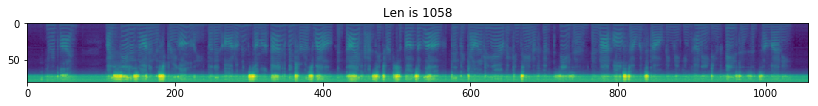

In [13]:
draw(x_train[0])

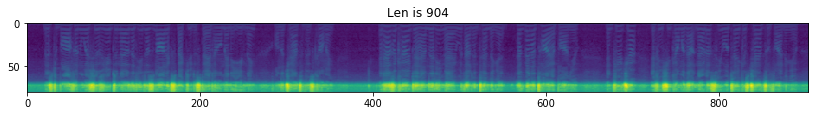

In [14]:
draw(x_train[2000])

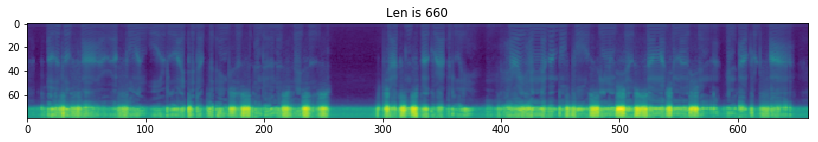

In [15]:
draw(x_val[1032])

## Keras

### Training - Only Conv2D

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Conv1D, GlobalMaxPool1D, MaxPool1D
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers
from keras.utils import Sequence

Using TensorFlow backend.


In [0]:
class Generator(Sequence):
    # Class is a dataset wrapper for better training performance
    def __init__(self, x_set, y_set, batch_size=256, shuffle=True):
        assert len(x_set) == len(y_set)
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.indices = np.arange(len(self.x))
        if shuffle:
          self.on_epoch_end()

    def __len__(self):
        return np.ceil(len(self.x) / self.batch_size).astype('int')

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x = np.take(self.x, inds)
        batch_y = np.take(self.y, inds)
        return list_to_sequence_vertically_padded(batch_x), batch_y
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [18]:
# Construct model
model = Sequential()

model.add(Conv1D(64, kernel_size=20, input_shape=(mx_h, 80), 
                 kernel_regularizer=regularizers.l2(0.1)))
model.add(GlobalMaxPool1D())

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.1)))
model.add(Dense(1, activation='sigmoid'))

model.compile('SGD', loss='binary_crossentropy', metrics=['accuracy'])

W0715 19:28:57.201511 140670608668544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 19:28:57.222089 140670608668544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 19:28:57.226509 140670608668544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 19:28:57.274887 140670608668544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0715 19:28:57.292754 140670608668544 deprecation_wrappe

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1381, 64)          102464    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 110,913
Trainable params: 110,913
Non-trainable params: 0
_________________________________________________________________


In [20]:
train_batch_size = 64
val_batch_size = 64
epochs = 2

history = model.fit_generator(generator=Generator(x_train, y_train, train_batch_size), 
                    validation_data=Generator(x_val, y_val, val_batch_size),
                    epochs=epochs)

W0715 19:29:13.226011 140670608668544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/2
375/375 [==============================] - 27s 71ms/step - loss: 8.8199 - acc: 0.9313 - val_loss: 4.1527 - val_acc: 0.9660
Epoch 2/2
375/375 [==============================] - 24s 63ms/step - loss: 2.4491 - acc: 0.9835 - val_loss: 1.3825 - val_acc: 0.9985


We have got almost 100% accuracy! Congratulations) Let's only save the model

In [0]:
model.save('model.h5')